# L&S 88 - Lab x - Data Visualization with `matplotlib.pyplot`
_Lab adapted by Chris Pyles from [Datahub Usage Analysis](https://github.com/berkeley-dsep-infra/datahub-usage-analysis)_

In this lab, we'll cover the basics of one of the most important aspects of data science: data visualization. By this point, you should have some familarity with data visualization from the builtin `Table` methods that allow you to create plots, histograms, and the like, but today we'll cover the tool that underlies all of those: `pyplot`. The `pyplot` library, a subset of a larger plotting library called `matplotlib`, is a very powerful (if unintiuitive) tool that allows you to create robust data visualizations in Python. While there are some other tools that can be used in conjunction with `pyplot` and which make the code easier to write and understand (e.g. `seaborn`, `altair`), we won't be covering those in this lesson.

Before you continue in this lab, please take time to complete the [`pyplot` tutorial](pyplot.ipynb). This will give you the basic building blocks to understand how to answer the questions in this lab.

In [6]:
from datascience import *
import numpy as np
import datetime as dt

# the standard pyplot abbreviation is plt
import matplotlib.pyplot as plt

# this sets the colorscheme and style of the plots create in this notebook
plt.style.use('fivethirtyeight')

# this Jupyter magic command tells IPython to display the plots right after they're generated
%matplotlib inline

from IPython import display

# reading in the tables you'll use
sessions_original = Table.read_table('sessions.csv')
sessions_original.show(5)
costs_original = Table.read_table('costs.csv')
costs_original.show(5)

start,stop,user,length_hours
2018-08-17 19:00:00-07:00,2018-08-17 20:00:00-07:00,0e67e203ba504e30970f3453c42d1d85b1eac911d250bf4cf88e69d8 ...,1
2018-08-17 20:00:00-07:00,2018-08-17 22:00:00-07:00,2780a01fae97591d4d8a70c1291db050dacc52c65f8e715c559e0827 ...,2
2018-08-18 08:00:00-07:00,2018-08-18 09:00:00-07:00,5de78aff194b7d24e760ecd386ea6e7532dbfbf04c6b12e8a68be098 ...,1
2018-08-20 17:00:00-07:00,2018-08-20 17:00:00-07:00,cc109c1c6ca3286c390399332890432d571f454e78562214f28ba698 ...,0
2018-08-22 12:00:00-07:00,2018-08-22 16:00:00-07:00,901110c7ea25931d4bb51ff13895d9a10edde0b9c607d54321360a75 ...,4


start_time,cost
2018-09-12 00:00:00-07:00,40.1569
2018-09-13 00:00:00-07:00,263.959
2018-09-14 00:00:00-07:00,233.379
2018-09-15 00:00:00-07:00,220.497
2018-09-16 00:00:00-07:00,221.476


## Part 1: Data Cleaning
Before we can do much with the data that we have collected, we need to do a bit of data cleaning. The first step in this process is to convert the dates in the dates in both tables to something that we can use to analyze time trends. Python has a builtin library called `datetime` (std. abbrev.: `dt`) which allows for robust comparison and manipulation of dates.

**Question 1:** The `convert_tr_to_dt` function (defined for you) converts a string to a `datetime` object. Apply this function to the `start` and `stop` columns of `sessions_original` and the `start_time` column of `costs_original`. Replace these columns with the arrays of `datetime` objects and store these new tables as `sessions` and `costs`, respectively.

In [7]:
def convert_str_to_dt(string):
    return dt.datetime.strptime(string[:-6], '%Y-%m-%d %H:%M:%S')

# ANSWER:
sessions_start_dt = sessions_original.apply(convert_str_to_dt, 'start')
sessions_stop_dt = sessions_original.apply(convert_str_to_dt, 'stop')

sessions = sessions_original.drop('start', 'start').with_columns(
    'start', sessions_start_dt,
    'stop', sessions_stop_dt
)
sessions.show(5)

costs_start_dt = costs_original.apply(convert_str_to_dt, 'start_time')

costs = costs_original.drop('start_time', 'start').with_columns(
    'start', costs_start_dt,
)
costs.show(5)
# END ANSWER

stop,user,length_hours,start
2018-08-17 20:00:00,0e67e203ba504e30970f3453c42d1d85b1eac911d250bf4cf88e69d8 ...,1,2018-08-17 19:00:00
2018-08-17 22:00:00,2780a01fae97591d4d8a70c1291db050dacc52c65f8e715c559e0827 ...,2,2018-08-17 20:00:00
2018-08-18 09:00:00,5de78aff194b7d24e760ecd386ea6e7532dbfbf04c6b12e8a68be098 ...,1,2018-08-18 08:00:00
2018-08-20 17:00:00,cc109c1c6ca3286c390399332890432d571f454e78562214f28ba698 ...,0,2018-08-20 17:00:00
2018-08-22 16:00:00,901110c7ea25931d4bb51ff13895d9a10edde0b9c607d54321360a75 ...,4,2018-08-22 12:00:00


cost,start
40.1569,2018-09-12 00:00:00
263.959,2018-09-13 00:00:00
233.379,2018-09-14 00:00:00
220.497,2018-09-15 00:00:00
221.476,2018-09-16 00:00:00


## Part 2: Daily active users and costs over time

We count someone as a "daily active user" if they start / stop their notebook server at least once. Due to anonimization techniques applied earlier, this might slightly undercount users.

**Question 2:** Get the number of daily active users in the `sessions` table and store this in a new table called `daily_active_users`. The new table should have two columns: `start` which has the start time and `count` which has the count of **unique** users. To this end, write a function called `num_unique_in_list` that counts the number of unique elements in a list (similar to an array).

_Hint 1:_ Passing the function `list` to `tbl.group()` will collect all of the values in the group into a list.

_Hint 2:_ The function `np.unique(arr)` returns an array of the unique values in `arr`.

In [8]:
# ANSWER:
def num_unique_in_list(l):
    return len(np.unique(l))

daily_active_users = sessions.select('start', 'user').group('start', list)
unique_users = daily_active_users.apply(num_unique_in_list, 'user list')
daily_active_users = daily_active_users.drop('user list').with_column('count', unique_users)
daily_active_users
# END ANSWER

start,count
2018-08-17 19:00:00,2
2018-08-17 20:00:00,3
2018-08-17 22:00:00,6
2018-08-17 23:00:00,2
2018-08-18 00:00:00,1
2018-08-18 08:00:00,17
2018-08-18 09:00:00,4
2018-08-18 10:00:00,1
2018-08-18 11:00:00,1
2018-08-18 13:00:00,8


We now want to visualize the number of daily active users over time. `pyplot` has the nice ability of being above to interpret time series from `datetime` objects, so passing an array of `datetime` objects as the $x$ parameter to a `pyplot` function will show changes of the $y$ parameter over time.

**Question 3a:** Add `pyplot` functions to the code cell below to give the graph a descriptive title and axis labels. Don't forget the semicolon so that nothing is printed!

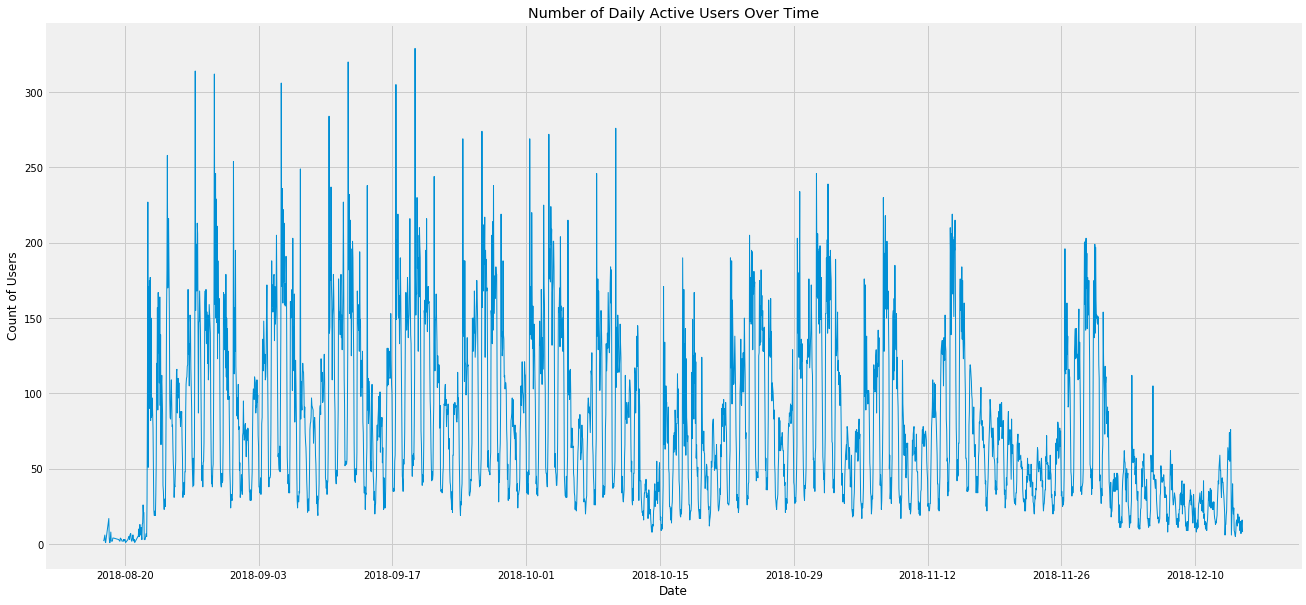

In [9]:
plt.figure(figsize=[20, 10])
plt.plot(daily_active_users.column('start'), daily_active_users.column('count'), linewidth=1.0)

# ANSWER:
plt.title('Number of Daily Active Users Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Users');
# END ANSWER

**Question 3b:** Compute the mean number of daily active users. Store this value as `mean_daily_active_users`.

In [5]:
# ANSWER:
mean_daily_active_users = np.mean(daily_active_users.column('count'))
# END ANSWER

print(f'Mean daily active users: {mean_daily_active_users: .2f}')

Mean daily active users:  79.89


**Question 4a:** Now we want to visualize how the costs are changing over time. Plot the `cost` column of the `costs` table against the `start` column. Use a line width of 1.

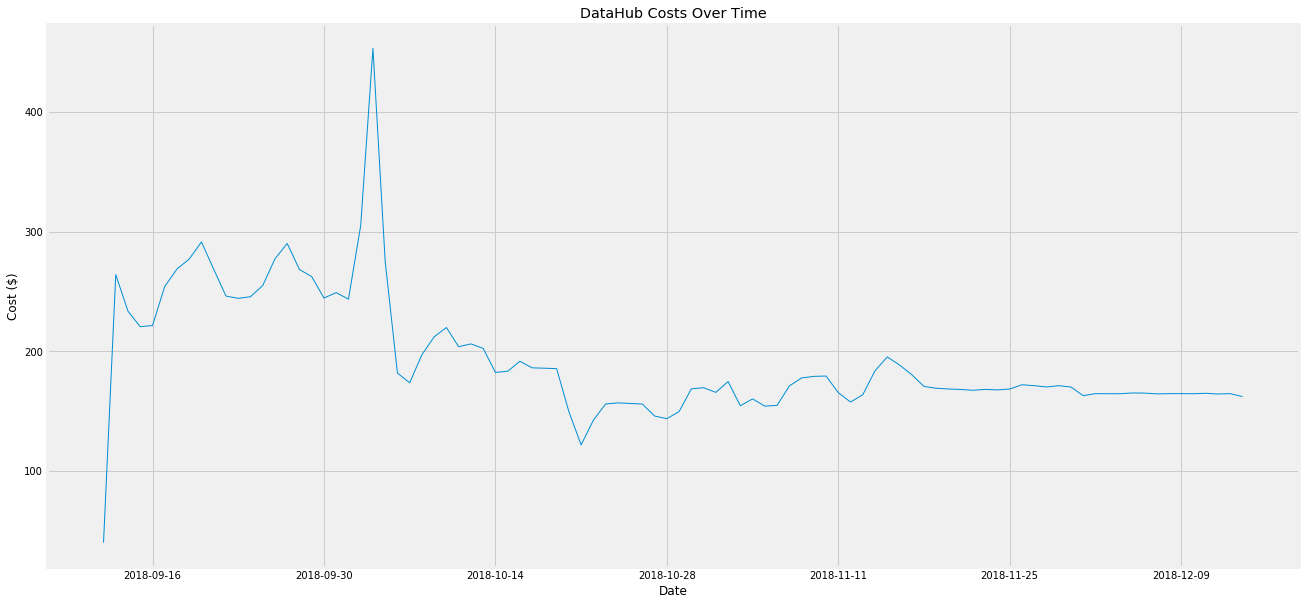

In [7]:
plt.figure(figsize=[20, 10])

# ASNWER:
plt.plot(costs.column('start'), costs.column('cost'), linewidth=1.0)
# END ANSWER

plt.title('DataHub Costs Over Time')
plt.xlabel('Date')
plt.ylabel('Cost ($)');

**Question 4b:** Compute the mean daily cost. Store this value as `mean_cost`.

In [ ]:
# ANSWER:
mean_cost = np.mean(costs.column('cost'))
# END ANSWER

print(f'Mean daily cloud cost: ${mean_cost: .2f}')

Lots of the users listed in the `sessions` table are not active; that is, they don't use their cluster. In this section, we want to see how the number of _active_ users changes over time and how much we are paying for each active user.

**Question 5a:** Create a table `total` which joins the `sessions` and `costs` tables on the start time. Add a new column `cost per active user` to the `total` table which has the `cost` column divided by the `count` column.

In [10]:
# ANSWER:
total = daily_active_users.join('start', costs)
total = total.with_column('cost per active user', total.column('cost') / total.column('count'))
total
# END ANSWER

start,count,cost,cost per active user
2018-09-12 00:00:00,92,40.1569,0.436488
2018-09-13 00:00:00,67,263.959,3.93968
2018-09-14 00:00:00,52,233.379,4.48805
2018-09-15 00:00:00,46,220.497,4.79342
2018-09-16 00:00:00,64,221.476,3.46056
2018-09-17 00:00:00,64,254.118,3.9706
2018-09-18 00:00:00,67,268.713,4.01065
2018-09-19 00:00:00,100,277.05,2.7705
2018-09-20 00:00:00,75,291.303,3.88404
2018-09-21 00:00:00,86,268.43,3.12128


**Question 5b:** plot the cost per active user over time. We won't give you any starter code except for setting the figure size, but your result should look like this:

<center><img src="q5b.png" width="1000px" /></center>

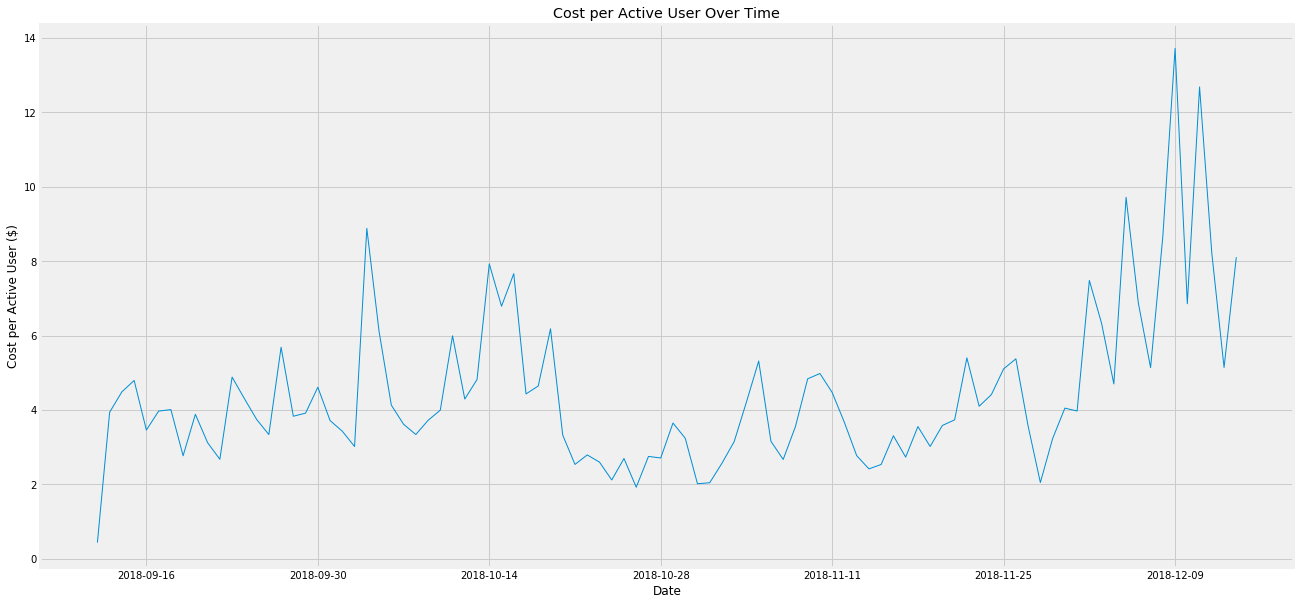

In [10]:
plt.figure(figsize=[20, 10])

# ANSWER:
plt.plot(total.column('start'), total.column('cost per active user'), linewidth=1.0)
plt.title('Cost per Active User Over Time')
plt.xlabel('Date')
plt.ylabel('Cost per Active User ($)');
# END ASNWER

## Part 2: Total Users

One way to count the "number of users on the JupyterHub" is to look at everyone who has ever started a notebook. Since anyone with a berkeley.edu account can log in, this is not the most accurate count of people who *use* the hub - but it's useful nonetheless.

In [11]:
user_starts_count = sessions.group('user')
print(f'Users who used JupyterHub at least once: {len(user_starts_count.rows)}')

Users who used JupyterHub at least once: 4850


We can calculate cost per day per user from this user count.

**Question 6:** Add a column to the table `total` csalled `cost per user` which has the `cost` column divided by the number of users who used JH at least once. Plot this column over time.

Ellipsis

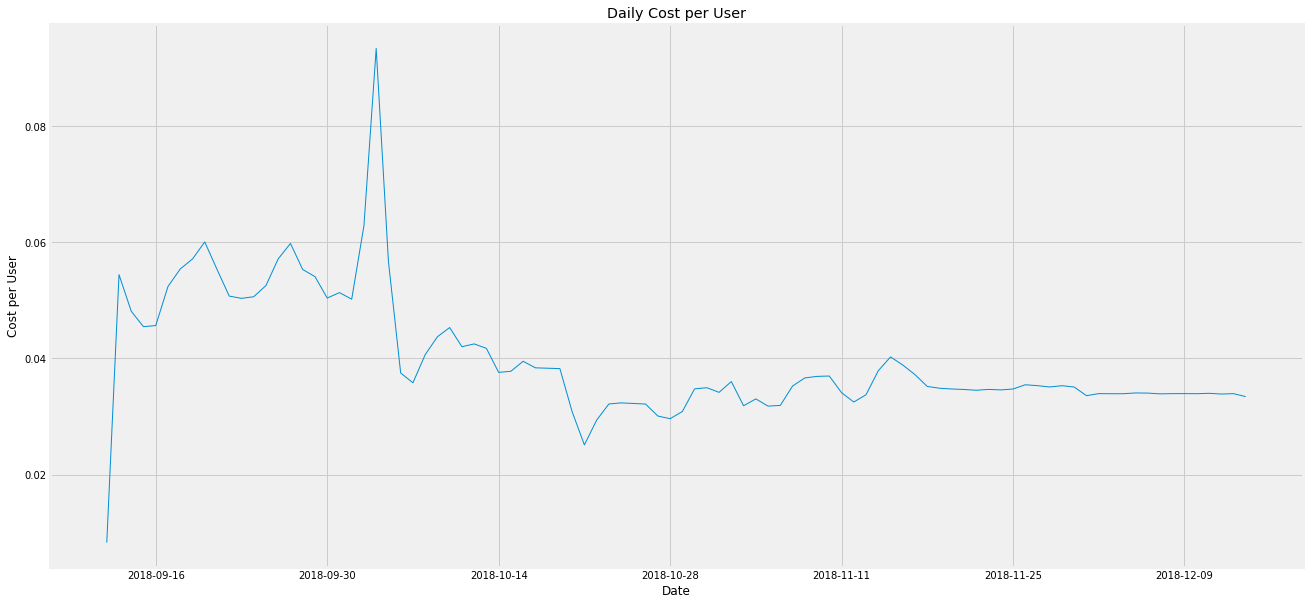

<Figure size 1440x720 with 0 Axes>

In [12]:
# ASNWER:
total = total.with_column('cost per user', total.column('cost') / len(user_starts_count.rows))

plt.figure(figsize=[20, 10])
plt.plot(total.column('start'), total.column('cost per user'), linewidth=1.0)
plt.title('Daily Cost per User')
plt.xlabel('Date')
plt.ylabel('Cost per User');
# END ANSWER

We can also figure out how much they cost per month. In the cell below, we extract the month from each `datetime` object and create a bar chart with the monthly cost per user.

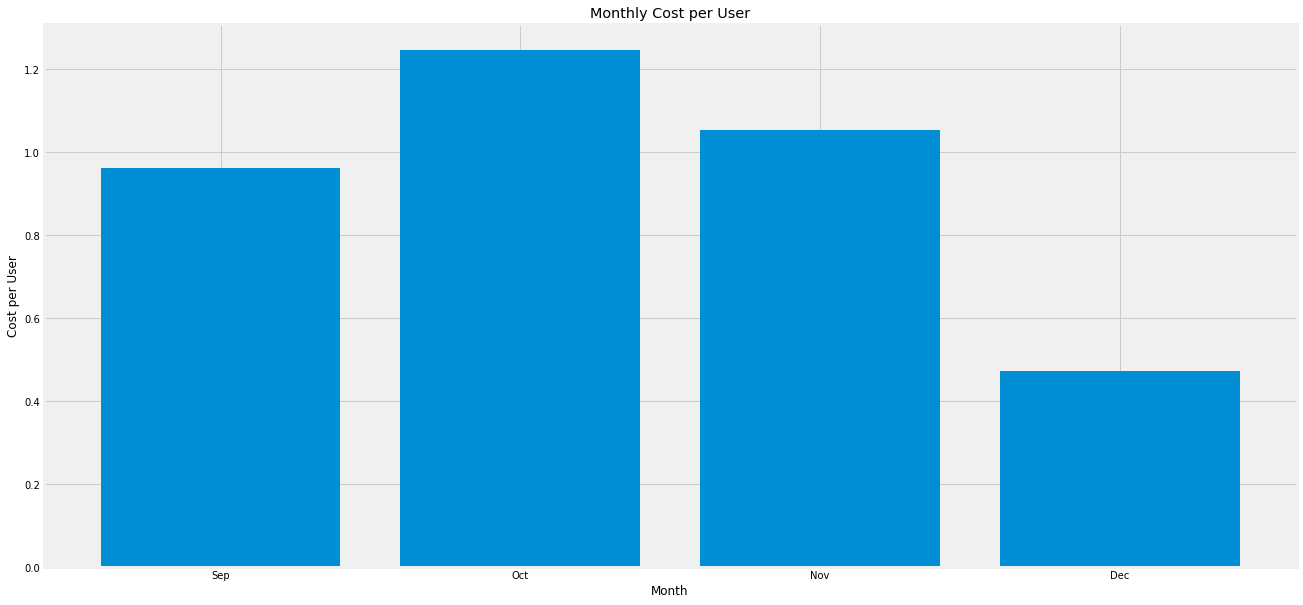

In [26]:
def dt_to_month(entry):
    return entry.strftime('%b')

monthly = costs.with_column('month', costs.apply(dt_to_month, 'start'))
monthly = monthly.group('month', sum)
monthly = monthly.with_column('cost per user', monthly.column('cost sum') / len(user_starts_count.rows)).sort('month', descending=True)

plt.figure(figsize=[20, 10])
plt.bar(monthly.column('month'), monthly.column('cost per user'))
plt.title('Monthly Cost per User')
plt.xlabel('Month')
plt.ylabel('Cost per User');

## Part 3: Realistic user count

A lot of people might log in a few times to JH to check it out, and then never really come back. We should avoid counting those as "users" when doing our cost analysis.  We can cut off outliers at the 99th percentile and plot a histogram to see how most people use JH.

**Question 7:** Use the `percentile` function to find the cutoff for the 99th percentile of the `count` column of the table `user_starts_count` and store it as `outlier_cutoff`. Plot a histogram of these counts where the count is below `outlier_cutoff` using bins of width 5 from 0 to 245. Make sure that you set the positions of the $x$ ticks and the limits of the axes so that your plot includes all of the data. The resulting plot should look like this:

<center><img src="q7.png" width="1000px" /></center>

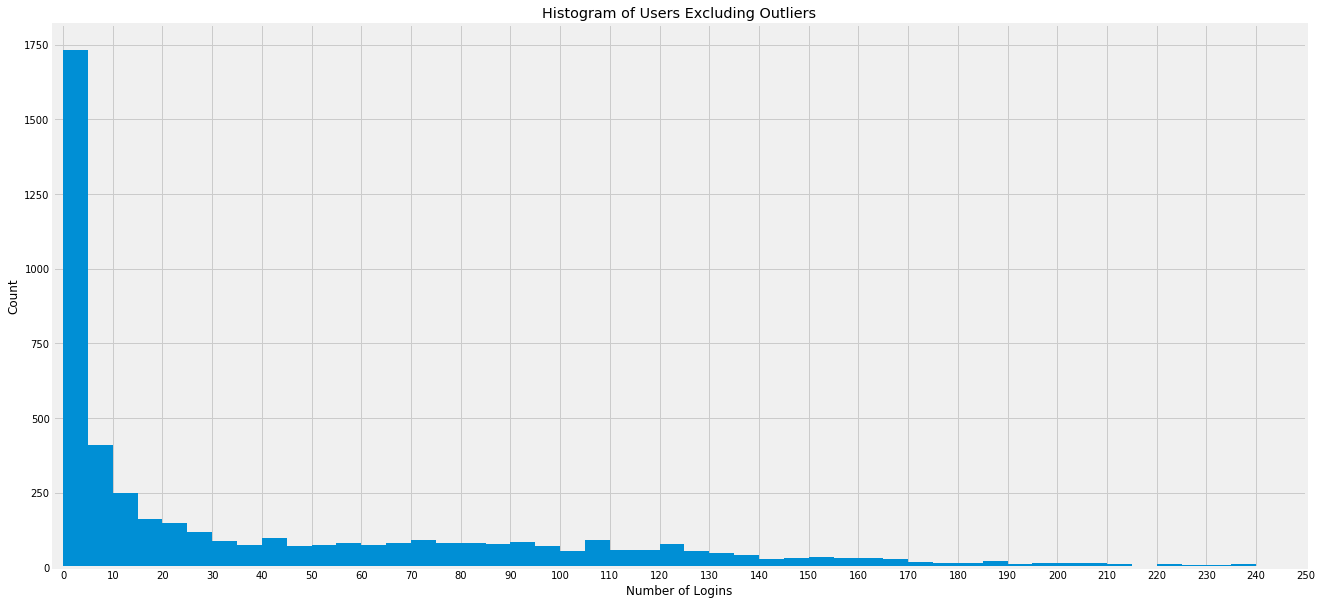

In [14]:
# ANSWER:
outlier_cutoff = percentile(99, user_starts_count.column('count'))

plt.figure(figsize=[20, 10])
plt.hist(user_starts_count.where('count', are.below(outlier_cutoff)).column('count'), bins=np.arange(0, 245, 5))
plt.xticks(np.arange(0, 251, 10))
plt.xlim([-2, 250])
plt.title('Histogram of Users Excluding Outliers')
plt.xlabel('Number of Logins')
plt.ylabel('Count');
# END ANSWER

There's a lot of users who use the hub <5 times, and many who use it 5-10 times. We pick an arbitrary cut off of ten notebook server starts to count as a "real" user and not someone just trying out the hub.

In [29]:
users_with_more_than_ten_starts = user_starts_count.where('count', are.above(10))
print(f"Users who used the hub more than 10 times: {len(users_with_more_than_ten_starts.rows)}")

Users who used the hub more than 10 times: 2646


**Question 8:** Plot the cost per "real" user by adding a new column `cost per realistic user` to the `total` table with the cost divided by the number of "real" users. Plot this value over time. Your plot should look like this:

<center><img src="q8.png" width="1000px" /></center>

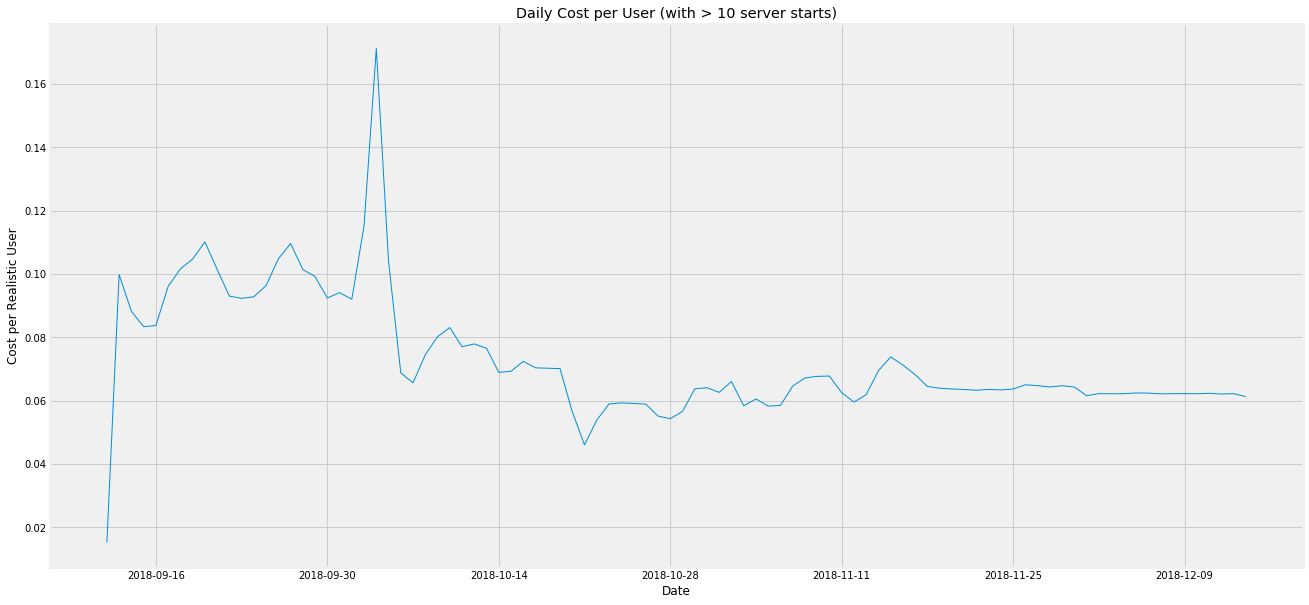

In [16]:
# ASNWER:
total = total.with_column('cost per realistic user', total.column('cost') /len(users_with_more_than_ten_starts.rows))

plt.figure(figsize=[20, 10])
plt.plot(total.column('start'), total.column('cost per realistic user'), linewidth=1.0)
plt.title('Daily Cost per User (with > 10 server starts)')
plt.xlabel('Date')
plt.ylabel('Cost per Realistic User');
# END ANSWER

**Question 9:** Recreate the bar chart that we made earlier in the `monthly` table but with the number of "real" users instead of daily users. Your plot should look like this:

<center><img src="q9.png" width="1000px" /></center>

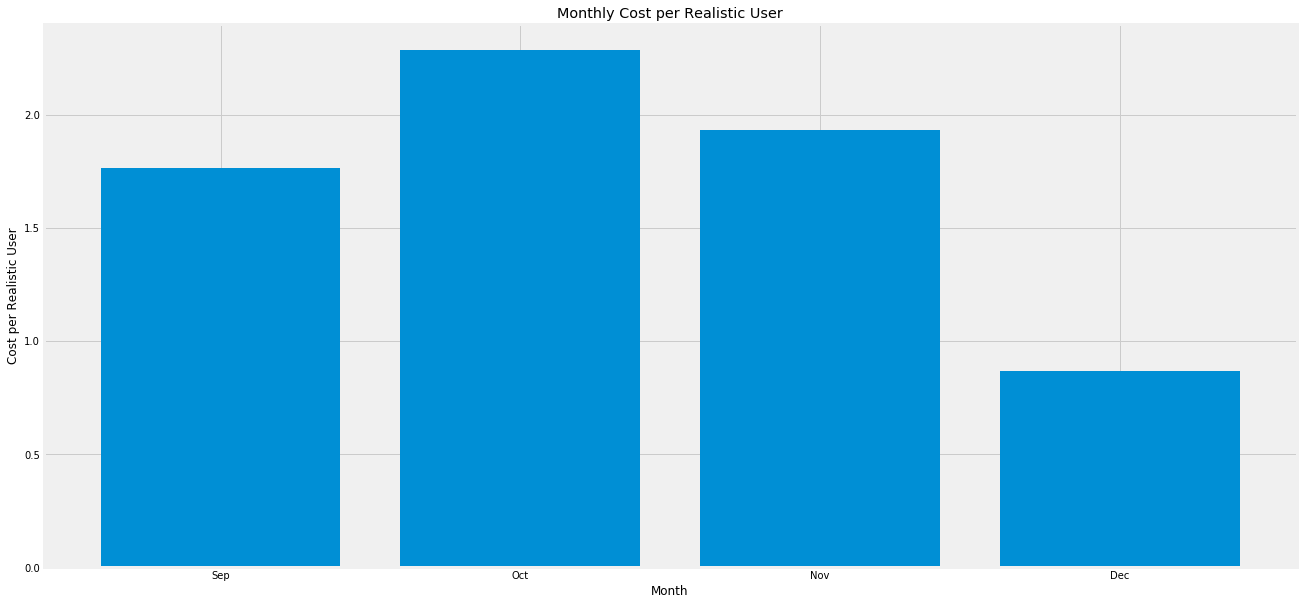

In [30]:
# ANSWER:
monthly = monthly.with_columns(
    'cost per realistic user', monthly.column('cost sum') / len(users_with_more_than_ten_starts.rows)
)

plt.figure(figsize=[20, 10])
plt.bar(monthly.column('month'), monthly.column('cost per realistic user'))
plt.title('Monthly Cost per Realistic User')
plt.xlabel('Month')
plt.ylabel('Cost per Realistic User');
# END ANSWER

## Part 4: Session length

Let's take a look at the distribution of the length of JH sessions. This data is in the `length_hours` column of the `sessions` table.

**Question 10:** Create a histogram of the session lengths. Your plot should look like this:

<center><img src="q10.png" width="1000px" /></center>

_Hint 1:_ Group by the `length_hours` column.

_Hint 2:_ You can set the width of the bars relative to their bin size using the `ridwth` parameter of `plt.hist()`.

_Hint 3:_ Notice that the bins are centered at the integer values rather than between them. How can we do this...?

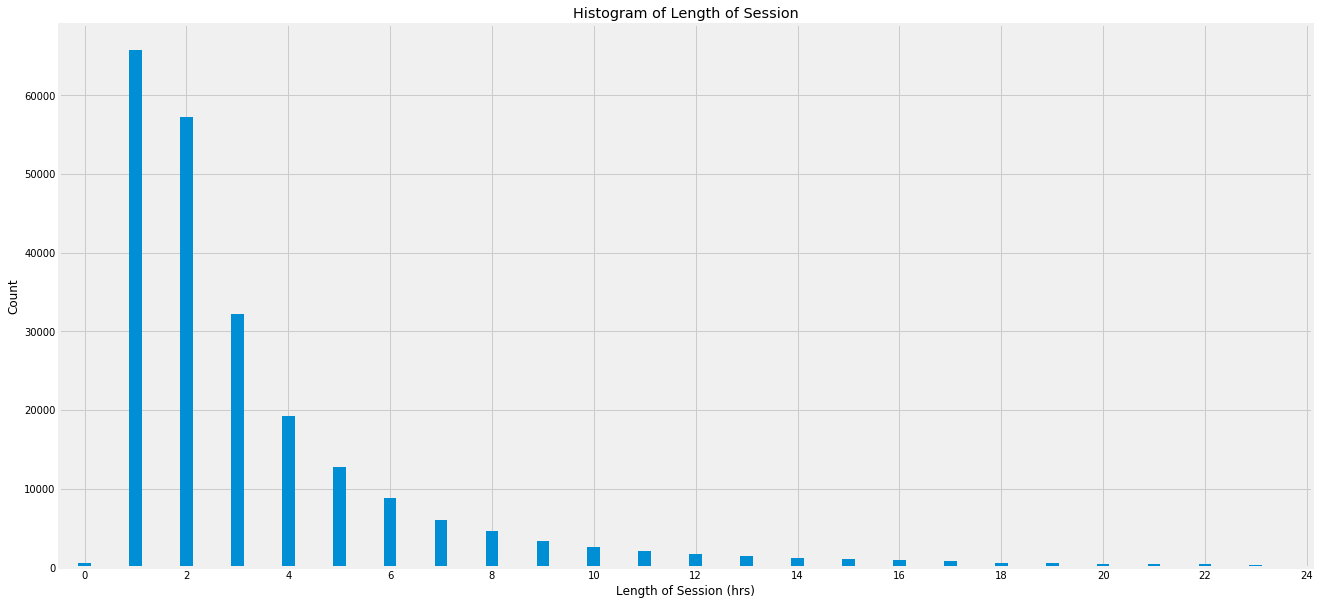

In [18]:
# ANSWER:
length_counts = sessions.group('length_hours')

plt.figure(figsize=[20, 10])
plt.hist(sessions.column('length_hours'), bins=np.arange(-0.5, 24.51, 1), rwidth=.25)
plt.xticks(np.arange(0, 25, 2))
plt.xlim([-.5, 24.1])
plt.title('Histogram of Length of Session')
plt.xlabel('Length of Session (hrs)')
plt.ylabel('Count');
# END ANSWER

## Submission
Please upload this notebook to your Github classroom repo for this assignment along with all of the other files in this directory. The ending filestructure in Github should look like this:

```
| your_assignment_repo
  | - datahub_usage_lab.ipynb
  | - pyplot.ipynb
  | - costs.csv
  | - q10.png
  | - q5b.png
  | - q7.png
  | - q8.png
  | - q9.png
  | - sessions.csv
```